In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

base_dir = Path().resolve().parent
data_dir = base_dir / 'data'
sys.path.append(str(base_dir))

In [5]:
data = pd.read_excel(data_dir / 'Project 2_2022.xlsx')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

features = ['Income', 'Outcome']  # Условные фичи
target = 'Balance'

X, y = data[features], data[target]

## Встроенный метод

Автоматические методы, по сути отбирающие признаки во время обучения (L1, L2 регуляризации)

Добавить при выборе основной модели

Пример:

In [28]:
from sklearn.svm import SVR

# В SVM по умолчанию присутствует L2 регуляризация
model = SVR(C=1, kernel='linear')
model.fit(X, y)

SVR(C=1, kernel='linear')

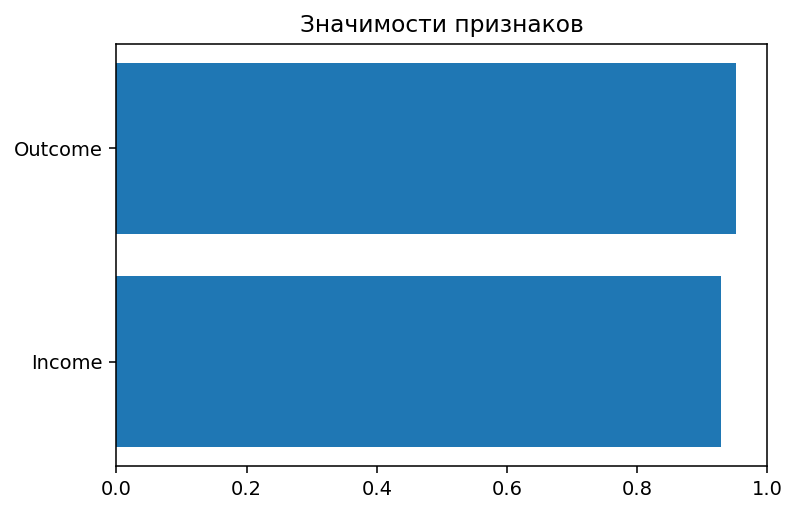

In [27]:
imps = model.coef_[0]

imps = abs(imps)
imps, features = zip(*sorted(zip(imps, features)))

plt.barh(range(len(features)), imps, align='center')
plt.yticks(range(len(features)), features)
plt.title('Значимости признаков');

## Оберточный метод - SequentialFeatureSelector

Для увеличения стабильности метода мы будем использовать кросс-валидацию во время использования этого метода, но обычная кросс-валидация нам не подойдет (так как мы работаем с временными рядами), поэтому будем использовать специальный сплит для временных рядов.

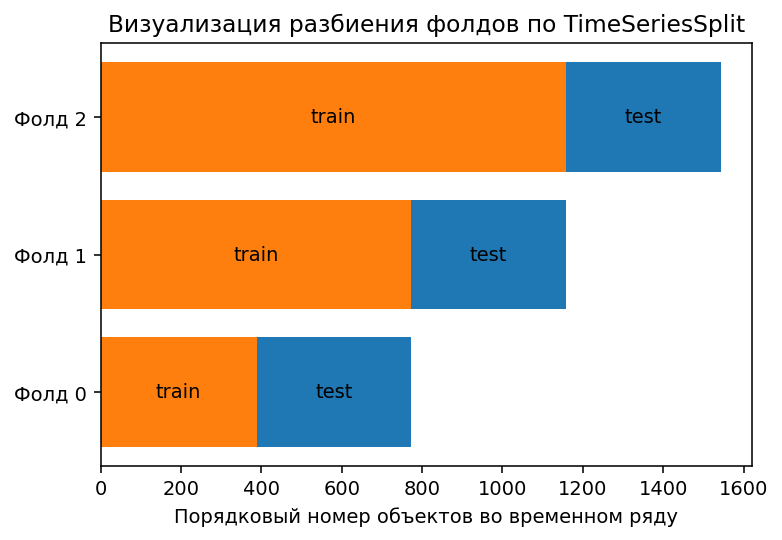

In [31]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for i, (train, test) in enumerate(tscv.split(data)):
    bar = plt.barh(f'Фолд {i}', train.shape[0], color='tab:orange')
    plt.bar_label(bar, labels=['train'], label_type='center')

    bar = plt.barh(f'Фолд {i}', test.shape[0], left=train.shape[0], color='tab:blue')
    plt.bar_label(bar, labels=['test'], label_type='center')

plt.title('Визуализация разбиения фолдов по TimeSeriesSplit')
plt.xlabel('Порядковый номер объектов во временном ряду');

In [37]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import SVR

model = SVR()
n_splits = 5
sfs = SequentialFeatureSelector(model, cv=TimeSeriesSplit(n_splits))
sfs.fit(X, y)

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                          estimator=SVR())

In [38]:
selected_features_mask = sfs.get_support()
selected_features = X.columns[selected_features_mask]
print(f'Выбранные признаки: {", ".join(selected_features)}')

Выбранные признаки: Outcome


## Фильтрационный метод - Correlation-based Feature Selection

In [4]:
from tslib.feature_selection import get_best_cfs_features

print(get_best_cfs_features.__doc__)
selected_features, _ = get_best_cfs_features(data, features, target)
print(f'Выбранные признаки: {", ".join(selected_features)}')


    Нахождение лучшего сабсета признаков на основе CFS - Correlation-based Feature Selection.
    По сути ищем признаки, сильно коррелирующие с таргетом, и слабо коррелирубщие между собой.
    Для нахождение сабсета используется жадный алгоритм, аналогичный sklearn.feature_selection.SequentialFeatureSelector с direction='forward', но без кросс-валидации
    
Выбранные признаки: Outcome


### Сравнение методов по стабильности

Будем проверять стабильность по тому, как сильно меняются метрики при тесте на разных фолдах

In [89]:
from collections import defaultdict

from tslib.scoring import get_score
from tslib.feature_selection import fit_default_model, fit_sfs_model, fit_cfs_model

tscv = TimeSeriesSplit(n_splits=5)

metric_dict = defaultdict(list)
key_rate = 0.07
day_deposit_rate = key_rate + 0.5 / 100
night_deposit_rate = key_rate - 0.9 / 100
night_loan_rate = key_rate + 1 / 100

for train_idx, test_idx in tscv.split(data):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    for method in ['default', 'sfs', 'cfs']:
        fit_func = globals()[f'fit_{method}_model']
        current_model, selected_features = fit_func(model, X_train, y_train)

        pred = current_model.predict(X_test[selected_features])
        score = get_score(y_test, pred, day_deposit_rate, night_deposit_rate, night_loan_rate)
        metric_dict[method].append(score)

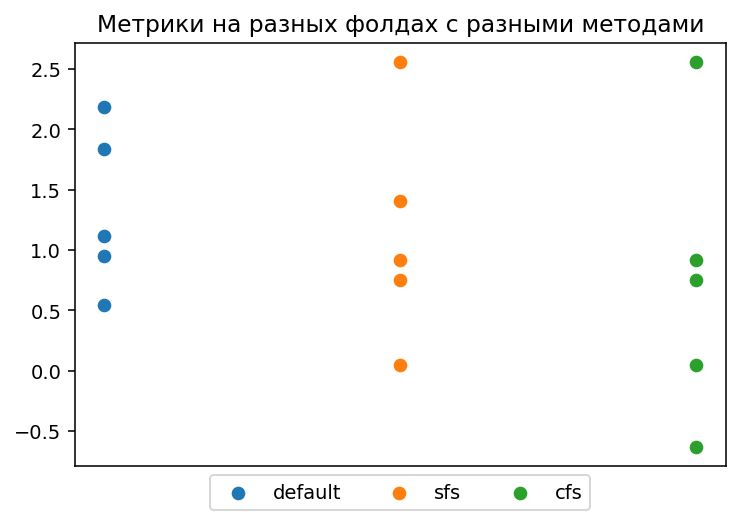

In [90]:
for i, (method, vals) in enumerate(metric_dict.items()):
    plt.scatter([i]*len(vals), vals, label=method)

plt.xticks([])
plt.legend(bbox_to_anchor=(0.5, 0), loc='upper center', ncol=3)
plt.title('Метрики на разных фолдах с разными методами');

In [91]:
fs_summary = pd.DataFrame(index=['mean', 'std'])
for method, vals in metric_dict.items():
    mean = np.mean(vals).round(2)
    std = np.std(vals).round(2)
    fs_summary[method] = [mean, std]

fs_summary

,default,sfs,cfs
mean,1.33,1.14,0.73
std,0.60,0.83,1.07
